In [1]:
# Import packages
import re
from pathlib import Path
import numpy as np
import pandas as pd
import os
from pdb import set_trace
import matplotlib.pyplot as plt
import PIL #for images
import copy

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.io import read_image
from torchvision import models, transforms

### Values set up

In [2]:
#Specifications
dataset_path = '/home/ec2-user/MLNotebooks/Datasets/'
image_path = '/home/ec2-user/MLNotebooks/ResNet50/'
# Data splitting and path
label_filepath = Path(dataset_path+'SubCellBarcode.MCF7.0622.txt')
image_folderpath = Path(image_path+'All_24by24Grid_dropna')
validation_fraction = 0.2

# Model weight
ModelWeightSpefication = 'random'

if ModelWeightSpefication == 'random':
    ModelWeights = None
if ModelWeightSpefication == 'pretrained':
    ModelWeights = models.resnet50.DEFAULT # it is the best available weight for resnet50 
    
# Optimizer
Weight_Decay = 0.0 # L2 regulator 
#  penalizes for too many weights - helps prevent overfitting
# 0.0001  or 0.001 gives higher acc

Momentum = 0.9
#  a way to smooth noise that is passed to the optimizer, 0.9
#  momentum is deterimental without label smoothing

Learner_rate = 1e-3
# was trying 5e-4

# Loss Function
Label_Smoothing = 0.1
#  was 0.1
#  sets the target of the loss function to something greater than 0 and less than 1
#  helps prevent overfitting

TransformOrNot = False

ApplyClassWeightToLoss = False
# Makes the loss weights equal to the fraction of each category label
# Note, a layer is added to the model so the outputs of the model are equal to the number of categories
#     This seems like a bug becuase that should already be the case

# Run the model
epochs = 100

### Device set up

In [3]:
# Check to see if the GPU is available and store it as a variable so tensors can be moved to it
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print('Is cuda available?:', torch.cuda.is_available())
print('cuda version:', torch.version.cuda)
dev = "cuda:0"

Using device: cuda
Is cuda available?: True
cuda version: 11.7


### Transformation set up

In [4]:
# Transformation
# transforms = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

### Custom image dataset set up

In [5]:
# Create the CustomImageDataset class from the parent Dataset class
class CustomImageDataset(Dataset):
    def __init__(self, input_df, img_dir, transform=None, target_transform=None, image_extension='.png'):
        self.img_labels = input_df
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.image_extension = image_extension

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0] + self.image_extension)
        image = read_image(img_path)
        #image = image.float()
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
            
        return image, label

### Training/Validation datasets set up

In [6]:
# Create a function to output training and validation annotation data frames from a single annotations file
def GetTrainValAnnotDataFrames(labels, img_dir, val_frac):
    # Inputs:
    # labels: a directory to an comma separated file with image filenames (no extention, so gene name) and their labels
    # img_dir: a directory to the folder containing the image files
    # val_frac: the fraction of samples used for validation
    
    # read the csv file with the sample annotations
    labels_df = pd.read_csv(labels, header=None, sep='\t', dtype=str)
    
    # read the directory containing the images to get a list of filenames
    #     strip the file extension so the filenames match the gene name in labels_df
    image_list = [file for file in os.listdir(img_dir) if not file.startswith('.')] # take care of hidden files
    gene_list = [os.path.splitext(file)[0] for file in image_list]  
    
    # remove entries in the labels_df that are not in the list of images
    #     this is done so that the training and validation sets are divided correctly
    common_indices = [item in gene_list for item in labels_df.iloc[:,0]]
    labels_df = labels_df.loc[common_indices,:]
    
    # extract unique class label into an array
    unique_labels = np.unique(labels_df.iloc[:,1])
    
    # split into training and validation set
    train_df, valid_df = train_test_split(labels_df, test_size=val_frac, random_state=42)
    
    print(f"Total labels: {len(labels_df)}")
    print(f"Total genes in training are {len(train_df)}; in validation are {len(valid_df)}; sum is {len(train_df)+len(valid_df)}")
    print(f"Unique labels: {unique_labels}")
    
    return train_df, valid_df, unique_labels

### Show image and label to tensor set up

In [7]:
# Function to convert a torchvision tensor to the default format for matplotlib
    # matplotlib.pyplot.imshow interprets an RGB vector as shape (N,M,3) 
    # torchvision.io.read_image reads an RGB image as shape (3,N,M)
def ShowTorchvisionImage(ImageTensor):
    ImageTensor_t1 = ImageTensor.transpose(1,2)
    ImageTensor_t2 = ImageTensor_t1.transpose(0,2)
    plt.imshow(ImageTensor_t2)
    
# Function to convert label numpy array to label tensor    
def LabelArray_to_Tensor(input_array,labels_unique):
    # converts a label array of strings to a tensor of floats
    # Inputs:
    #   input_array: the array of strings that are labels
    #   labels_unique: an ordered list of the unique labels possible for the data set
    # Outputs:
    #   output_tensor: a tensor of floats, one unique float corresponding to each label
    
    int_label = np.arange(0,len(labels_unique))
    i = 0
    for label in labels_unique:
        indices = [label == item for item in input_array]
        input_array[indices] = int_label[i]
        i = i+1

    input_array = input_array.astype(float)
    output_tensor = torch.as_tensor(input_array)
    output_tensor = output_tensor.long()
  
    return(output_tensor)

### Training and testing epoch loop set up

In [8]:
# Function for training the weights of the model
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss

        X = X.to(torch.float32) # convert to float32 to avoid error stating byte expected but found float
        X = X.to(dev)
        pred = model(X) # predict classes using images from the training set
        
        # convert the labels into a tensor of intigers and compute the loss
        y = np.asarray(y)
        y = LabelArray_to_Tensor(y,unique_label_array)
        y = y.to(dev)
        loss = loss_fn(pred, y) # compute the loss based on model output and real labels

        # Backpropagation
        optimizer.zero_grad() # zero the parameter gradients 
        loss.backward() # backpropagate the loss
        optimizer.step() # adjust parameters based on the calculated gradients
             

    loss = loss.item() # extract the loss value
    
    return(loss)
            
# Function for validating the weights of the model
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            
            # convert to float32 to avoid error stating byte expected but found float
            X = X.to(torch.float32)
            X = X.to(dev)
            pred = model(X)
            
            # convert the labels into a tensor of intigers and compute the loss
            y = np.asarray(y)
            y = LabelArray_to_Tensor(y,unique_label_array)
            y = y.to(dev)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    
    return(test_loss,correct)

### Pretrained model set up

In [9]:
# Define the model (pretrained)

# initial model weights
# model = models.resnet50(weights=ModelWeights)
model = models.resnet50(weights=None) # without initial weights defined - good for patients not re-arranged
model.fc.out_features = 4

# Update the out channels to match with number of class in our data
if ApplyClassWeightToLoss:
    model = models.resnet50()
    model.fc.out_features = 4
    
#     for p in model.parameters(): # Freeze all parameters in the network
#         p.requires_grad = False
    
#     for p in model.classifier.parameters(): # Make classification layer trainable
#         p.requires_grad = True 
        
#     for p in model.features[-1].parameters(): # retrain the last layers [-3:-1] mean last three layers
#         p.requires_grad = True
    
model = model.to(dev)

# see the model architecture if desired
model.parameters

<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 2

### Loss function and unbalanced class weight set up

In [10]:
# Define the loss function
# This needs to be made general for the number of classes

# funciton call
# training, validation, unique_label_array = GetTrainValAnnotDataFrames(labels=label_filepath, img_dir=image_folderpath, val_frac=validation_fraction)

# Wrap data into the custom pytorch dataset class
# if TransformOrNot:
#     TrainingData = CustomImageDataset(input_df=training,img_dir=image_folderpath, transform=transforms)
#     ValidationData = CustomImageDataset(input_df=validation,img_dir=image_folderpath, transform=transforms)
# else:
#     TrainingData = CustomImageDataset(input_df=training,img_dir=image_folderpath)
#     ValidationData = CustomImageDataset(input_df=validation,img_dir=image_folderpath)
    
# loss function

if ApplyClassWeightToLoss:
    # Nate's weight tensor([ 2.2273, 13.4550,  3.5913,  5.0439]
    # Weights for each class for loss function
#     n_cytosol = float(sum(TrainingData.img_labels.iloc[:,1]=='Cytosol'))
#     n_mitochondria = float(sum(TrainingData.img_labels.iloc[:,1]=='Mitochondria'))
#     n_nuclear = float(sum(TrainingData.img_labels.iloc[:,1]=='Nuclear'))
#     n_secretory = float(sum(TrainingData.img_labels.iloc[:,1]=='Secretory'))
#     n_total = len(TrainingData.img_labels.iloc[:,1])
    
    # zhuoheng's weight
    # train_weight = compute_sample_weight('balanced', y=train_labels)
    LossWeights = torch.tensor([0.59259259,5.33333333,0.84210526,1.06666667]).to(device)
    loss_fn = nn.CrossEntropyLoss(label_smoothing=Label_Smoothing)

else:
    loss_fn = nn.CrossEntropyLoss(label_smoothing=Label_Smoothing)
    
# https://medium.com/@zergtant/use-weighted-loss-function-to-solve-imbalanced-data-classification-problems-749237f38b75

### Optimizer set up

In [11]:
# Define the optimizer
def Optimizer(name, model):
    if name == 'SGD_weight':
        optimizer = torch.optim.SGD(model.parameters(), lr=Learner_rate, weight_decay=Weight_Decay, momentum=Momentum)
    if name == 'SGD_default':
        optimizer = torch.optim.SGD(model.parameters(), lr=Learner_rate)
    if name == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=Learner_rate, weight_decay=Weight_Decay)
        
    return optimizer

### Early stopping set up

In [12]:
# criterion = torch.optim.lr_scheduler.ReduceLROnPlateau(monitor='val_loss', patience=5)

### Actual training

In [13]:
# funciton call
training, validation, unique_label_array = GetTrainValAnnotDataFrames(labels=label_filepath, img_dir=image_folderpath, val_frac=validation_fraction)

Total labels: 4791
Total genes in training are 3832; in validation are 959; sum is 4791
Unique labels: ['Cytosol' 'Mitochondria' 'Nuclear' 'Secretory']


Label: Cytosol


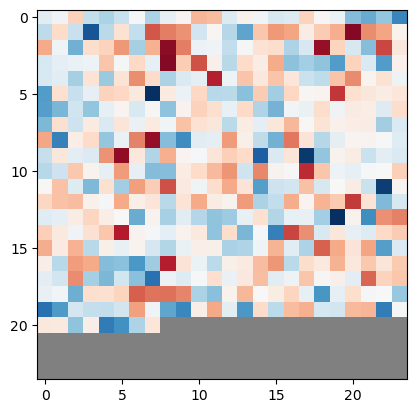

In [14]:
# Wrap data into the custom pytorch dataset class
if TransformOrNot:
    TrainingData = CustomImageDataset(input_df=training,img_dir=image_folderpath, transform=transforms)
    ValidationData = CustomImageDataset(input_df=validation,img_dir=image_folderpath, transform=transforms)
else:
    TrainingData = CustomImageDataset(input_df=training,img_dir=image_folderpath)
    ValidationData = CustomImageDataset(input_df=validation,img_dir=image_folderpath)

# Define Data Loaders
train_dataloader = DataLoader(TrainingData, batch_size=64, shuffle=True)
val_dataloader = DataLoader(ValidationData, batch_size=64, shuffle=True)

# Display a training image and its corresponding label.
train_features, train_labels = next(iter(train_dataloader))
img = train_features[0].squeeze() #no squeeze
label = train_labels[0]
ShowTorchvisionImage(img)
print(f"Label: {label}")

In [15]:
# Run the model

# set up performance dataframe to record loss and accuracy of each epoch
PerformanceDF = pd.DataFrame(index=range(epochs),columns=['Epoch','TrainLoss','ValLoss','TrainAcc','ValAcc'])
print(f"{'Epoch':>5s}{'Train Loss':>13s}{'Val Loss':>11s}{'Train Accuracy':>17s}{'Val Accuracy':>15s}\n")

# call optimizer
optimizer = Optimizer('Adam', model)
    
for t in range(epochs): 
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    val_loss, val_accuracy = test_loop(val_dataloader, model, loss_fn)
    train_loss2, train_accuracy = test_loop(train_dataloader, model, loss_fn)
    Epoch = t
    print(f"{str(Epoch):>5s}{train_loss:>13f}{val_loss:>11f}{train_accuracy:>16f}{val_accuracy:>14f}")
    PerformanceDF.loc[t,:]=[Epoch,train_loss,val_loss,train_accuracy,val_accuracy]
    
    # note: I am not sure how to load the MSD into the model
    if Epoch == 0:
        highest_val_accuracy = 0 
        MSD0 = copy.deepcopy(model.state_dict())
    if val_accuracy > highest_val_accuracy:
        highest_val_accuracy = val_accuracy
        MSD_Best = copy.deepcopy(model.state_dict())
    
print("Done!")

Epoch   Train Loss   Val Loss   Train Accuracy   Val Accuracy

    0     1.900496   2.080489        0.623956      0.546403
    1     1.850048   1.942605        0.733559      0.600626
    2     1.649247   1.937866        0.813674      0.616267
    3     1.555153   1.837314        0.887526      0.672576
    4     1.504979   1.967479        0.893789      0.662148
    5     1.226503   1.971104        0.927192      0.692388
    6     1.207984   2.024194        0.944154      0.675704
    7     1.409579   2.045826        0.943633      0.683003
    8     1.189749   2.109497        0.952505      0.689260
    9     1.145591   2.080943        0.954593      0.681960
   10     1.344016   2.097722        0.963727      0.715328
   11     1.212441   2.117236        0.961900      0.710115
   12     1.080828   2.244226        0.968424      0.698644
   13     1.209389   2.126235        0.968424      0.713243
   14     1.120393   2.154479        0.977818      0.718457
   15     1.321460   2.209804        

In [16]:
train_loss2, train_accuracy

(1.0359597623348236, 0.994258872651357)

In [17]:
print('Best recorded epoch validation accuracy: ' + str(round(100*highest_val_accuracy,2)))

BestModel = copy.deepcopy(model)
BestModel.load_state_dict(MSD_Best)
val_loss,best_val_accuracy = test_loop(val_dataloader, BestModel, loss_fn)
print('Best epoch recalculated validation accuracy: ' + str(round(100*best_val_accuracy,2)))

FirstModel = copy.deepcopy(model)
FirstModel.load_state_dict(MSD0)
val_loss,first_val_accuracy = test_loop(val_dataloader, FirstModel, loss_fn)
print('First epoch validation Accuracy: ' + str(round(100*first_val_accuracy,2)))

Best recorded epoch validation accuracy: 79.14
Best epoch recalculated validation accuracy: 78.31
First epoch validation Accuracy: 55.79


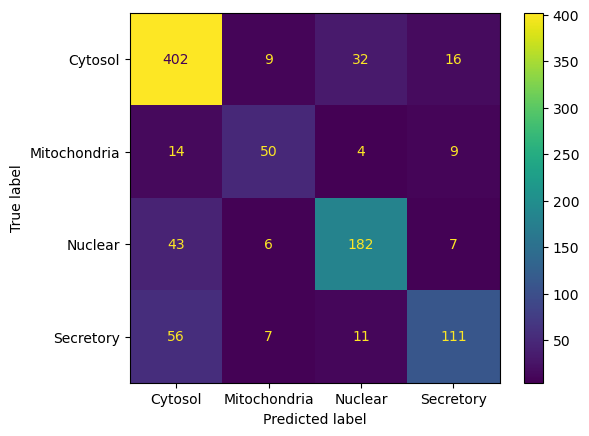

In [18]:
# build confusion matrix
#   https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sn

y_pred = []
y_true = []

# iterate over test data
for X, y in val_dataloader:
    
        X = X.to(torch.float32)
        X = X.to(dev)
        output = model(X) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        output_string = [unique_label_array[i] for i in output]
        
        y_pred.extend(output_string) # Save Prediction
        
        labels = y
        y_true.extend(labels) # Save Truth

# constant for classes
# classes = unique_labels

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=unique_label_array)
disp.plot()
plt.show()
# cf_matrix_norm = np.zeros((len(classes),len(classes)))
# for i in np.arange(0,len(classes)):
#     cf_matrix_norm[i,:] = cf_matrix[i,:]/sum(cf_matrix[i,:])

# df_cm = pd.DataFrame(cf_matrix_norm, index = [i for i in classes],
#                      columns = [i for i in classes])
# plt.figure(figsize = (6,5))
# hm = sn.heatmap(df_cm, annot=True)
# hm.set(xlabel='\n\nPrediction', ylabel='Label\n\n')
# plt.savefig('output.png')

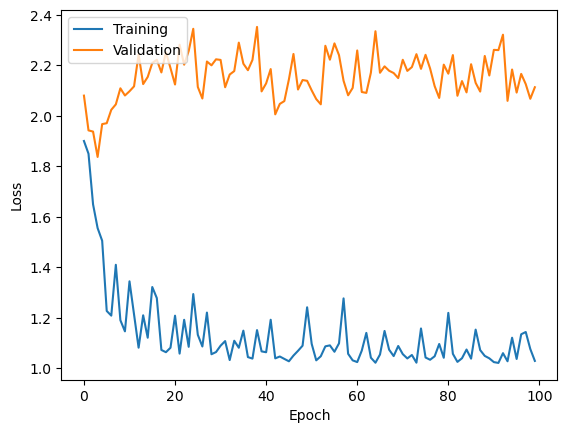

In [19]:
# Graph accuracy for training and validation loss

import matplotlib.pyplot as plt
plt.plot(PerformanceDF['Epoch'], PerformanceDF['TrainLoss'])
plt.plot(PerformanceDF['Epoch'], PerformanceDF['ValLoss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend(['Training', 'Validation'], loc='upper left')
#plt.savefig('loss_all_24x24_dropna.pdf')
plt.show()

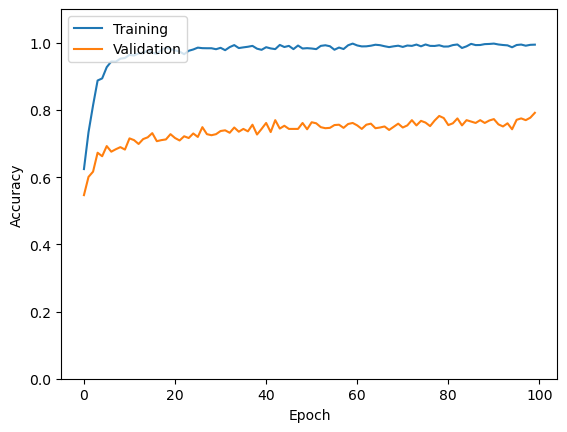

In [20]:
# Graph accuracy for training and validation

import matplotlib.pyplot as plt
plt.plot(PerformanceDF['Epoch'], PerformanceDF['TrainAcc'])
plt.plot(PerformanceDF['Epoch'], PerformanceDF['ValAcc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0,1.1])
plt.legend(['Training', 'Validation'], loc='upper left')
#plt.savefig('accuracy_all_24x24_dropna.pdf')
plt.show()

In [21]:
# Validate Orientation of Confusion Matrix
#     Data labels go down the rows and predictions label the columns

# Print Confusion Matrix Row Sums
ConfusionMatrix_RowSums = [sum(cf_matrix[i,:]) for i in np.arange(0,len(unique_label_array))]
print(ConfusionMatrix_RowSums)

# Print Quantity of Items with each label
ValDF_UniqueLabelSums = [sum(validation.iloc[:,1]==unique_label_array[i]) for i in np.arange(0,len(unique_label_array))]
print(ValDF_UniqueLabelSums)

[459, 77, 238, 185]
[459, 77, 238, 185]
